# Intro
**MaxActivation** generates the image that would maximize activation per convolutional layer in a model (i.e. *cifar.json*)

In [133]:
import os, pdb, json, re, keras, vis_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential, load_model, Model, model_from_json
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Input, InputLayer
from keras.utils import np_utils, generic_utils
from keras import backend as K
from PIL import Image
import numpy as np
from tqdm import tnrange, tqdm_notebook
import gc
import time

# File Loaders
Load the neccesary files

In [134]:
model_json = vis_utils.json_load('models.json')

In [135]:
model_type = 'cifar'
top_level= [_dir for _dir in os.listdir(model_type) if not _dir.startswith('.')]
dir_paths = {entry:os.path.join(model_type, entry) for entry in top_level}
jsons = os.listdir(dir_paths['jsons'])
model_dirs = [os.path.splitext(_item)[0] for _item in jsons]

# Activation Generator

In [142]:
_BASEDIM = model_json[model_type]['vis_dim'][0]
vis_root = np.random.random((1,_BASEDIM, _BASEDIM,3))*20+110
#for idx in tqdm_notebook(range(len(jsons)), desc="Models"):
idx = 5
print('Starting with ' + jsons[idx])
dir_list = vis_utils.dir_list_returner(dir_paths, ['weights','max_activations','history','supplement'], model_dirs[idx])
#Set up supplemental parameters
compile_params = vis_utils.json_load(os.path.join(dir_list['supplement'], 'compile.json'))
activation_params = vis_utils.json_load(os.path.join(dir_list['supplement'], 'activation.json'))
activation_layers = [str(_layer) for _layer in activation_params['snip_layer']]
# Loading the Model file
with open(os.path.join(dir_paths['jsons'],jsons[idx]), 'r') as model_file:
    model = model_from_json(model_file.read())
compile_params = vis_utils.json_load(os.path.join(dir_list['supplement'], 'compile.json'))
    # Loading the Model file
model.compile(loss = compile_params['loss'], optimizer = compile_params['optimizer'], metrics=compile_params['metrics'])
vis_model = vis_utils.snip_test(model, activation_layers)
vis_compute_graph = vis_utils.build_cg(vis_model)

weight_files = [_file for _file in os.listdir(dir_list['weights']) if _file.startswith('weights')]
weight_files.sort()
#for wt_idx in tqdm_notebook(range(len(weight_files)), desc = jsons[idx], leave=False):
for wt_idx in tqdm_notebook([14], desc = jsons[idx], leave=False):
#wt_idx = 15
    weight_folder = os.path.join(dir_list['max_activations'], 'epoch'+str(wt_idx))
    make = os.makedirs(weight_folder) if not os.path.exists(weight_folder) else None
    # Building the second model and set the weights
    model.load_weights(os.path.join(dir_list['weights'], weight_files[wt_idx]))
    vis_model = vis_utils.snip_build(model, activation_layers)
    #extract the convolutional layers
    conv_layers = vis_utils.get_conv_layers(vis_model)
    for lyr_idx, vis_layer in enumerate(tqdm_notebook(conv_layers, desc="Layer", leave=False)):
    #for lyr_idx, vis_layer in enumerate(conv_layers):
        conv_folder = os.path.join(weight_folder, vis_layer)
        make = os.makedirs(conv_folder) if not os.path.exists(conv_folder) else None
        #_BASEDIM = model_json[model_type]['vis_dim'][0]
        kernel_size = vis_model.get_layer(vis_layer).get_config()['filters']
        for knl_idx, vis_kernel in enumerate(tqdm_notebook(range(kernel_size), desc="Kernel", leave=False)):
        #for knl_idx, vis_kernel in enumerate(range(kernel_size)):
            kernel_file = os.path.join(conv_folder, 'kernel' + str(vis_kernel)+'.png')
            # Create random root image
            vis_iters = model_json[model_type]["vis_iters"][0]
            vis_root = np.random.random((1,_BASEDIM, _BASEDIM,3))*20+110
            image = vis_utils.visualize_filter_cg(vis_kernel, vis_root, vis_layer, vis_compute_graph, vis_iters)
            #layerDict[vis_layer]['sources'].append(vis_utils.visualize_filter(vis_kernel, vis_root, vis_layer, vis_model, vis_iters))
            Image.fromarray(vis_utils.tensor_to_image(image)).save(kernel_file)
            #gc.collect()

Starting with cifar_2.json


KeyboardInterrupt: 

In [137]:
vis_iters

150

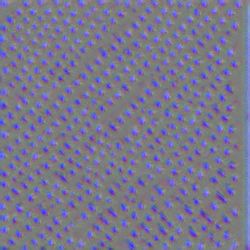

In [132]:
vis_kernel = 18
vis_root = np.random.random((1,_BASEDIM, _BASEDIM,3))
vis_iters = 150
image = vis_utils.visualize_filter_cg(vis_kernel, vis_root, vis_layer, vis_compute_graph, vis_iters)
            #layerDict[vis_layer]['sources'].append(vis_utils.visualize_filter(vis_kernel, vis_root, vis_layer, vis_model, vis_iters))
Image.fromarray(vis_utils.tensor_to_image(image))

In [63]:
_BASEDIM = 250